In [1]:
#사전작업
from tensorflow import keras
from sklearn.model_selection import train_test_split

#데이터 읽기
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)
#레이어 만들기
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))
#콜백 설정 후 컴파일하기
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/20
1500/1500 [==============================] - 64s 42ms/step - loss: 0.5153 - accuracy: 0.8143 - val_loss: 0.3302 - val_accuracy: 0.8777
Epoch 2/20
1500/1500 [==============================] - 62s 41ms/step - loss: 0.3432 - accuracy: 0.8779 - val_loss: 0.2950 - val_accuracy: 0.8891
Epoch 3/20
1500/1500 [==============================] - 62s 42ms/step - loss: 0.2962 - accuracy: 0.8942 - val_loss: 0.2625 - val_accuracy: 0.9015
Epoch 4/20
1500/1500 [==============================] - 62s 42ms/step - loss: 0.2651 - accuracy: 0.9035 - val_loss: 0.2386 - val_accuracy: 0.9107
Epoch 5/20
1500/1500 [==============================] - 63s 42ms/step - loss: 0.2399 - accuracy: 0.9114 - val_loss: 0.2412 - val_accuracy: 0.9079
Epoch 6/20
1500/1500 [==============================] - 65s 43ms/step - loss: 0.2191 - accuracy: 0.9197 - val_loss: 0.2339 - val_accuracy: 0.9147
Epoch 7/20
1500/1500 [==============================] - 62s 4

In [2]:
#체크포인트 파일을 읽어옴
model = keras.models.load_model('best-cnn-model.h5')
model.layers      #레이어를 표시

In [3]:
#합성곱 층의 가중치 확인
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)     #층의 가중치와 절편은 weights 속성에 저장

(3, 3, 1, 32) (32,)


In [6]:
#가중치 배열의 평균과 표준편차 계산

conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(), conv_weights.std())

-0.016555257 0.25243273


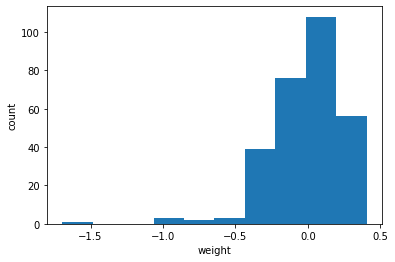

In [7]:
#가중치의 분포를 확인
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

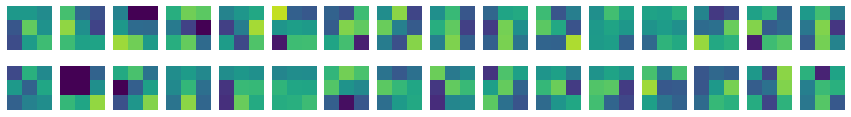

In [10]:
#32개의 커널 출력
fig, axs = plt.subplots(2, 16, figsize = (15, 2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
    axs[i, j].axis('off')
plt.show()

In [11]:
#훈련하지 않은 빈 합성곱 신경망을 만들어 비교
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [12]:
#평균과 표준편차
no_training_weight = no_training_conv.weights[0].numpy()
print(no_training_weight.mean(), no_training_weight.std())

0.006940571 0.08033163


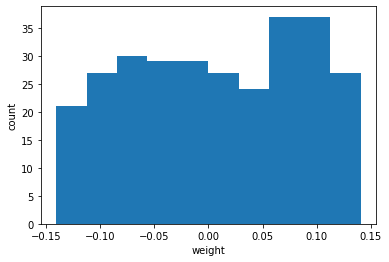

In [14]:
#히스토그램 그래프
plt.hist(no_training_weight.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

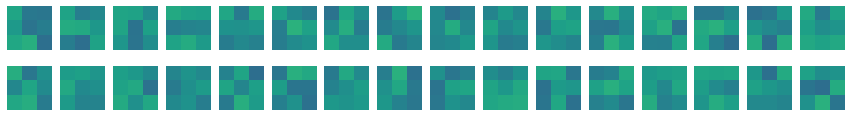

In [15]:
#커널을 출력
fig, axs = plt.subplots(2, 16, figsize = (15, 2))
for i in range(2):
  for j in range(16):
    axs[i, j].imshow(no_training_weight[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
    axs[i, j].axis('off')
plt.show()

지금까지는 신경망 모델을 만들 때 keras Sequential 클래스를 사용했다. 이 클래스는 층을 차례대로 쌓은 모델을 만든다. 그러나 만약 입력이나 출력이 여러개인 경우에는 Sequential 클래스를 사용하기 어렵다. 대신 __함수형 API(functional API)__를 사용한다.<br/>
함수형 API는 keras의 Model 클래스를 사용하여 모델을 만든다.

In [16]:
#모델의 입력은 input 속성으로 참조할 수 있다.
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


In [17]:
#model.input과 model.layers[0].output을 연결하는 새로운 모델을 만듬
conv_acti = keras.Model(model.input, model.layers[0].output)

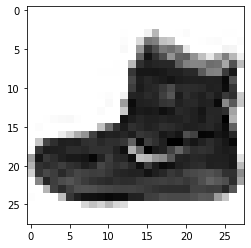

In [18]:
#keras로 패션 MNIST 데이터셋을 읽은 후 훈련세트에 있는 첫번 째 샘플을 그림
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

(1, 28, 28, 32)


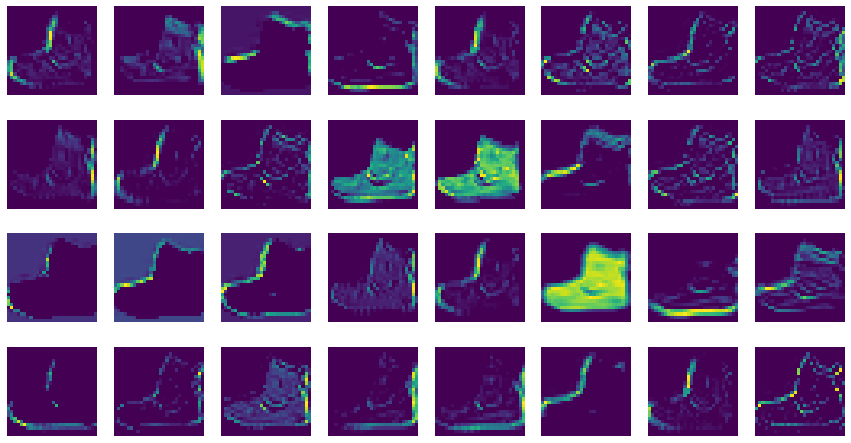

In [22]:
#샘플을 conv_acti 모델에 주입하여 첫번째 합성층이 만드는 특성 맵을 출력
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)      #최종 출력층의 확률을 반환
print(feature_maps.shape)     #(1, 28, 28, 32) 샘플이 하나이므로 첫번째 차원이 1이다.
fig, axs = plt.subplots(4, 8, figsize = (15, 8))
for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
    axs[i, j].axis('off')
plt.show()

(1, 14, 14, 64)


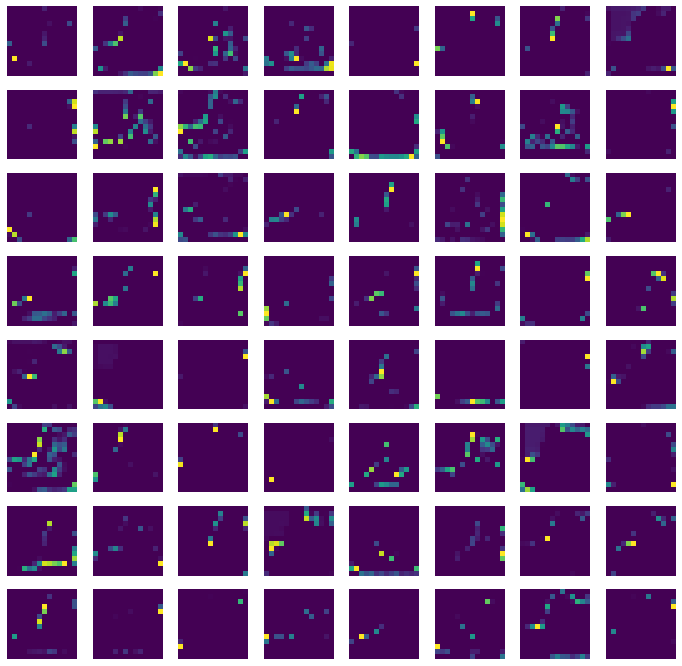

In [23]:
#두번째 합성층에 대해서도 같은 과정 시행
conv2_acti = keras.Model(model.input, model.layers[2].output)
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)
print(feature_maps.shape)     #(1, 14, 14, 64) 샘플이 하나이므로 첫번째 차원이 1이다.
fig, axs = plt.subplots(8, 8, figsize = (12, 12))
for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0,:,:,i*8 + j])
    axs[i, j].axis('off')
plt.show()      #합성곱을 진행할수록 직관적으로 이해하기 어려워짐.